# **Chapter 16.2b - Deep Learning Practicum**

## Using Harmonizome Datasets to Predict Gene Function

The Harmonizome resource developed by the Ma'ayan Lab can be used to perform Machine Learning tasks to predict unknown annotations for genes and proteins.

In this notebook, we'll be using literature curated knowledge as labels to for genes and Gene Perturbation data from experiments in GEO as the data. We'll train a classifier which can predict whether or not a given gene is likely to be associated with a particular disease given how that gene responded to perturbations in other genes.

To access the data, you can download the data from https://maayanlab.cloud/Harmonizome/ or to use the [Harmonizome api](https://maayanlab.cloud/Harmonizome/documentation).

In [2]:
# Ensure all necessary dependencies are installed
%pip install numpy sklearn pandas scipy tensorflow_gpu supervenn matplotlib

# Import all required modules for this notebook
import numpy as np
import sklearn as sk
import sklearn.model_selection
import pandas as pd
import tensorflow as tf
from supervenn import supervenn
from matplotlib import pyplot as plt
from IPython.display import display

# Verify a GPU was detected & registered
tf.config.list_physical_devices('GPU')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**[DISEASES Curated Gene-Disease Assocation Evidence Scores](https://maayanlab.cloud/Harmonizome/dataset/DISEASES+Curated+Gene-Disease+Assocation+Evidence+Scores)**

DISEASES contains associations between genes anad diseases which were manually curated from literature.

**Original Data**
- The original data before it was processed by Harmonizome can be found at <https://diseases.jensenlab.org/Downloads>

**Citations**
- [Pletscher-Frankild, S et al. (2015) DISEASES: text mining and data integration of disease-gene associations. Methods. 74:83-9.](http://www.ncbi.nlm.nih.gov/pubmed/25484339)

In [3]:
labels_name = 'DISEASES Curated Gene-Disease Associations'
labels = pd.read_table('https://maayanlab.cloud/static/hdfs/harmonizome/data/jensendiseasecurated/gene_attribute_matrix.txt.gz', header=[0, 1, 2], index_col=[0, 1, 2], encoding='latin1', compression='gzip')
labels

#                             hemangioblastoma von hippel-lindau disease  \
#                                    DOID:5241                DOID:14175   
GeneSym                                     na                        na   
SNAP29 ENSP00000215730 9342                0.0                       0.0   
TRPV3  ENSP00000301365 162514              0.0                       0.0   
AAGAB  ENSP00000261880 79719               0.0                       0.0   
CTSC   ENSP00000227266 1075                0.0                       0.0   
KRT6C  ENSP00000252250 286887              0.0                       0.0   
...                                        ...                       ...   
LZTFL1 ENSP00000296135 54585               0.0                       0.0   
IFT27  ENSP00000343593 11020               0.0                       0.0   
HDAC8  ENSP00000362674 55869               0.0                       0.0   
INPP5E ENSP00000360777 56623               0.0                       0.0   
TRIM32 ENSP00000363095 22954               0.0                       0.0   

#                             hemangioma cell type benign neoplasm  \
#                               DOID:255              DOID:0060084   
GeneSym                               na                        na   
SNAP29 ENSP00000215730 9342          0.0                       0.0   
TRPV3  ENSP00000301365 162514        0.0                       0.0   
AAGAB  ENSP00000261880 79719         0.0                       0.0   
CTSC   ENSP00000227266 1075          0.0                       0.0   
KRT6C  ENSP00000252250 286887        0.0                       0.0   
...                                  ...                       ...   
LZTFL1 ENSP00000296135 54585         0.0                       0.0   
IFT27  ENSP00000343593 11020         0.0                       0.0   
HDAC8  ENSP00000362674 55869         0.0                       0.0   
INPP5E ENSP00000360777 56623         0.0                       0.0   
TRIM32 ENSP00000363095 22954         0.0                       0.0   

#                             benign neoplasm polycythemia  \
#                                DOID:0060072    DOID:8432   
GeneSym                                    na           na   
SNAP29 ENSP00000215730 9342               0.0          0.0   
TRPV3  ENSP00000301365 162514             0.0          0.0   
AAGAB  ENSP00000261880 79719              0.0          0.0   
CTSC   ENSP00000227266 1075               0.0          0.0   
KRT6C  ENSP00000252250 286887             0.0          0.0   
...                                       ...          ...   
LZTFL1 ENSP00000296135 54585              0.0          0.0   
IFT27  ENSP00000343593 11020              0.0          0.0   
HDAC8  ENSP00000362674 55869              0.0          0.0   
INPP5E ENSP00000360777 56623              0.0          0.0   
TRIM32 ENSP00000363095 22954              0.0          0.0   

#                             primary polycythemia  \
#                                       DOID:10780   
GeneSym                                         na   
SNAP29 ENSP00000215730 9342                    0.0   
TRPV3  ENSP00000301365 162514                  0.0   
AAGAB  ENSP00000261880 79719                   0.0   
CTSC   ENSP00000227266 1075                    0.0   
KRT6C  ENSP00000252250 286887                  0.0   
...                                            ...   
LZTFL1 ENSP00000296135 54585                   0.0   
IFT27  ENSP00000343593 11020                   0.0   
HDAC8  ENSP00000362674 55869                   0.0   
INPP5E ENSP00000360777 56623                   0.0   
TRIM32 ENSP00000363095 22954                   0.0   

#                             organ system benign neoplasm  \
#                                             DOID:0060085   
GeneSym                                                 na   
SNAP29 ENSP00000215730 9342                            0.0   
TRPV3  ENSP00000301365 162514                          0.0   
AAGAB  ENSP0000026

**[GEO Signatures of Differentially Expressed Genes for Gene Perturbations](https://maayanlab.cloud/Harmonizome/dataset/GEO+Signatures+of+Differentially+Expressed+Genes+for+Gene+Perturbations)**

The Gene Expression Omnibus (GEO) contains data from many experiments, this particular dataset contains rich information about the relationships between genes by measuring the expression of genes when a given gene is knocked out, over expressed, or mutated.

**Original Data**
- Can be accessed on GEO at <https://www.ncbi.nlm.nih.gov/geo/>.

**Citations**
- [Barrett, T et al. (2013) NCBI GEO: archive for functional genomics data sets--update. Nucleic Acids Res. 41:D991-5.](http://www.ncbi.nlm.nih.gov/pubmed/23193258)
- [Edgar, R et al. (2002) Gene Expression Omnibus: NCBI gene expression and hybridization array data repository. Nucleic Acids Res. 30:207-10.](http://www.ncbi.nlm.nih.gov/pubmed/11752295)

In [4]:
X_name = 'GEO Gene Perturbagens'
data = pd.read_table('https://maayanlab.cloud/static/hdfs/harmonizome/data/geogene/gene_attribute_matrix.txt.gz', header=[0, 1, 2], index_col=[0, 1, 2], encoding='latin1', compression='gzip')
data

#                 NIX_Deficiency_GDS2630_160_mouse_spleen  \
#                                                     NIX   
GeneSym                                                na   
RPL7P52 na 646912                                     0.0   
ZNF731P na 729806                                     0.0   
MED15   na 51586                                      0.0   
ZIM2    na 23619                                      0.0   
ABCA11P na 79963                                      0.0   
...                                                   ...   
GGT7    na 2686                                       0.0   
HAUS7   na 55559                                      0.0   
PSPN    na 5623                                       0.0   
GALK2   na 2585                                       0.0   
PHF8    na 23133                                      0.0   

#                 NIX_Deficiency_GDS2630_655_mouse_Spleen  \
#                                                     NIX   
GeneSym                                                na   
RPL7P52 na 646912                                     0.0   
ZNF731P na 729806                                     0.0   
MED15   na 51586                                      0.0   
ZIM2    na 23619                                      0.0   
ABCA11P na 79963                                      0.0   
...                                                   ...   
GGT7    na 2686                                       0.0   
HAUS7   na 55559                                      0.0   
PSPN    na 5623                                       0.0   
GALK2   na 2585                                       0.0   
PHF8    na 23133                                      0.0   

#                 AIRE_KO_GDS2274_246_mouse_Medullary thymic epithelial cells (with high CD80 expression)  \
#                                                                                                    AIRE   
GeneSym                                                                                                na   
RPL7P52 na 646912                                                0.0                                        
ZNF731P na 729806                                                0.0                                        
MED15   na 51586                                                 0.0                                        
ZIM2    na 23619                                                 0.0                                        
ABCA11P na 79963                                                 0.0                                        
...                                                              ...                                        
GGT7    na 2686                                                  0.0                                        
HAUS7   na 55559                                                 0.0                                        
PSPN    na 5623                                                  0.0                                        
GALK2   na 2585                                                  0.0                                        
PHF8    na 23133                                                 0.0                                        

#                 PDX1_KO_GDS4348_360_mouse_Proximal small intestine  \
#                                                               PDX1   
GeneSym                                                           na   
RPL7P52 na 646912                                                0.0   
ZNF731P na 729806                                                0.0   
MED15   na 51586                                                 0.0   
ZIM2    na 23619                                                 0.0   
ABCA11P na 79963                                                 0.0   
...                                                              ...   
GGT7    na 2686                                                  0.0   
HAUS7   na 55559                           

Using the literature curated diseases associated with genes, and the relationships gene have with one another we expect to be able to identify additional genes, not yet annotated as such, which should be associated with a given disease.

In [5]:
labels.sum().sort_values().iloc[-20:]

#                                        #             GeneSym
developmental disorder of mental health  DOID:0060037  na          220.0
specific developmental disorder          DOID:0060038  na          220.0
eye disease                              DOID:5614     na          231.0
eye and adnexa disease                   DOID:1492     na          231.0
globe disease                            DOID:1242     na          231.0
disease of mental health                 DOID:150      na          240.0
neurodegenerative disease                DOID:1289     na          249.0
autosomal genetic disease                DOID:0050739  na          269.0
inherited metabolic disorder             DOID:655      na          272.0
monogenic disease                        DOID:0050177  na          298.0
sensory system disease                   DOID:0050155  na          300.0
cancer                                   DOID:162      na          326.0
disease of cellular proliferation        DOID:14566    na    

Let's consider "eye diseases" since it seems we might be able to get a sufficient amount of genes annotated with this disease term.

In [6]:
y_name = f"Eye Diseases from {labels_name}"
# Find all labels in the DISEASES matrix columns which contain the string "eye"
labels.columns.levels[0][labels.columns.levels[0].str.contains('eye')]

Index(['eye and adnexa disease', 'eye disease'], dtype='object', name='#')

In [7]:
# Subset the DISEASES label matrix, selecting only the eye columns
eye_labels = labels.loc[:, pd.IndexSlice[labels.columns.levels[0][labels.columns.levels[0].str.contains('eye')], :, :]]
eye_labels

#                             eye and adnexa disease eye disease
#                                          DOID:1492   DOID:5614
GeneSym                                           na          na
SNAP29 ENSP00000215730 9342                      0.0         0.0
TRPV3  ENSP00000301365 162514                    0.0         0.0
AAGAB  ENSP00000261880 79719                     0.0         0.0
CTSC   ENSP00000227266 1075                      0.0         0.0
KRT6C  ENSP00000252250 286887                    0.0         0.0
...                                              ...         ...
LZTFL1 ENSP00000296135 54585                     0.0         0.0
IFT27  ENSP00000343593 11020                     0.0         0.0
HDAC8  ENSP00000362674 55869                     0.0         0.0
INPP5E ENSP00000360777 56623                     0.0         0.0
TRIM32 ENSP00000363095 22954                     0.0         0.0

[2252 rows x 2 columns]

In [8]:
# Collapse the matrix into a single vector indexed by the gene symbols (level=0)
#  using 1 if any of the columns contain 1, otherwise 0
y = eye_labels.groupby(level=0).any().any(axis=1).astype(int)
display(y)
# report the count of each value (0/1)
y.value_counts()

AAAS      0
AAGAB     0
AARS      0
AARS2     0
AASS      0
         ..
ZNF513    1
ZNF521    0
ZNF592    0
ZNF711    0
ZNF81     0
Length: 2252, dtype: int64

0    2021
1     231
dtype: int64

y represents labels of genes known to be associated with an eye disease while 0 means it is *unknown*. We can see that there are very few genes known to be associated with eye disease compared to unknown.

It's now time to prepare the "data" matrix from GEO Knockout/Knockdown experiments.

In [9]:
# This collapses the multi index on row and column which will be easier to work
#  with. since these are all unique we can use first without losing information,
#  we can verify this by noticing that the shape remains the same after this operation.
X = data.groupby(level=0).first().T.groupby(level=0).first().T
display(X)
display(data.shape)
display(X.shape)

#          A2BAR_Deficiency_GDS3662_520_mouse_Heart  \
1060P11.3                                       0.0   
A1BG                                            0.0   
A1BG-AS1                                        0.0   
A1CF                                            0.0   
A2M                                             0.0   
...                                             ...   
ZYG11A                                          0.0   
ZYG11B                                         -1.0   
ZYX                                             0.0   
ZZEF1                                           0.0   
ZZZ3                                            0.0   

#          ABCA1_OE_GDS2303_189_mouse_LDL receptor-deficient livers  \
1060P11.3                                                0.0          
A1BG                                                     0.0          
A1BG-AS1                                                 0.0          
A1CF                                                     0.0          
A2M                                                      0.0          
...                                                      ...          
ZYG11A                                                   0.0          
ZYG11B                                                   0.0          
ZYX                                                      0.0          
ZZEF1                                                    0.0          
ZZZ3                                                     0.0          

#          ACADM_KO_GDS4546_512_mouse_liver  \
1060P11.3                               0.0   
A1BG                                    0.0   
A1BG-AS1                                0.0   
A1CF                                    0.0   
A2M                                     1.0   
...                                     ...   
ZYG11A                                  0.0   
ZYG11B                                  0.0   
ZYX                                     0.0   
ZZEF1                                   0.0   
ZZZ3                                    0.0   

#          ACHE_OE_GDS891_241_mouse_Prefrontal cortex  \
1060P11.3                                         0.0   
A1BG                                              0.0   
A1BG-AS1                                          0.0   
A1CF                                              0.0   
A2M                                               0.0   
...                                               ...   
ZYG11A                                            0.0   
ZYG11B                                            0.0   
ZYX                                               0.0   
ZZEF1                                             0.0   
ZZZ3                                              0.0   

#          ADNP_Deficiency - NULL MUTATION_GDS2540_691_mouse_E9 embryos - Heterozygous mutant  \
1060P11.3                                                0.0                                    
A1BG                                                     0.0                                    
A1BG-AS1                                                 0.0                                    
A1CF                                                     0.0                                    
A2M                                                      0.0                                    
...                                                      ...                                    
ZYG11A                                                   0.0                                    
ZYG11B                                                   0.0                                    
ZYX                                                      0.0                                    
ZZEF1                                                    0.0                                    
ZZZ3                                                     0.0                                    

#          ADNP_Deficiency - NULL MUTATION_GDS2540_692_mouse_E9 embryos

(22021, 739)

(22021, 739)

We're now getting ready to use `X` and `y` for machine learning. We'll first need to align the two, that-is make operate on a common, shared set of genes. We'll use SuperVenn to visualize the overlap between genes in the labels and in the underlying data we're using for machine learning.

/home/u8sand/.local/lib/python3.10/site-packages/supervenn/_plots.py:402: UserWarning: Parameters figsize and dpi of supervenn() are deprecated and will be removed in a future version.
Instead of this:
    supervenn(sets, figsize=(8, 5), dpi=90)
Please either do this:
    plt.figure(figsize=(8, 5), dpi=90)
    supervenn(sets)
or plot into an existing axis by passing it as the ax argument:
    supervenn(sets, ax=my_axis)

  warnings.warn(


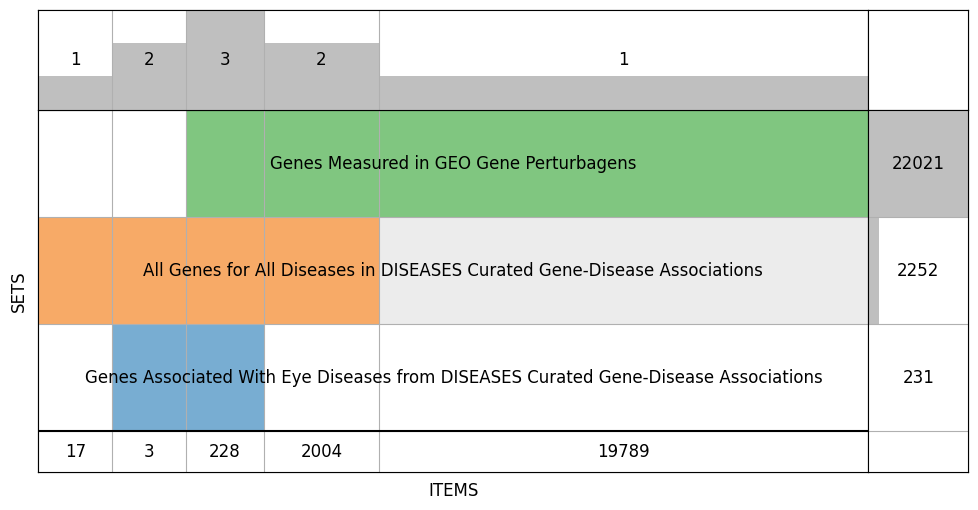

In [10]:
# This shows gene overlap between the labeled genes and the genes in our data
supervenn([
  set(y[y==1].index),
  set(y.index),
  set(X.index),
], [
  f"Genes Associated With {y_name}",
  f"All Genes for All Diseases in {labels_name}",
  f"Genes Measured in {X_name}",
], widths_minmax_ratio=0.15, figsize=(12, 6))

In [11]:
# this matches y's index with X, wherever y doesn't have a gene in x we get an NaN which we'll just assign as 0
X, y = X.align(y, axis=0, join='left')
y = y.fillna(0)
display(X)
display(y)

#          A2BAR_Deficiency_GDS3662_520_mouse_Heart  \
1060P11.3                                       0.0   
A1BG                                            0.0   
A1BG-AS1                                        0.0   
A1CF                                            0.0   
A2M                                             0.0   
...                                             ...   
ZYG11A                                          0.0   
ZYG11B                                         -1.0   
ZYX                                             0.0   
ZZEF1                                           0.0   
ZZZ3                                            0.0   

#          ABCA1_OE_GDS2303_189_mouse_LDL receptor-deficient livers  \
1060P11.3                                                0.0          
A1BG                                                     0.0          
A1BG-AS1                                                 0.0          
A1CF                                                     0.0          
A2M                                                      0.0          
...                                                      ...          
ZYG11A                                                   0.0          
ZYG11B                                                   0.0          
ZYX                                                      0.0          
ZZEF1                                                    0.0          
ZZZ3                                                     0.0          

#          ACADM_KO_GDS4546_512_mouse_liver  \
1060P11.3                               0.0   
A1BG                                    0.0   
A1BG-AS1                                0.0   
A1CF                                    0.0   
A2M                                     1.0   
...                                     ...   
ZYG11A                                  0.0   
ZYG11B                                  0.0   
ZYX                                     0.0   
ZZEF1                                   0.0   
ZZZ3                                    0.0   

#          ACHE_OE_GDS891_241_mouse_Prefrontal cortex  \
1060P11.3                                         0.0   
A1BG                                              0.0   
A1BG-AS1                                          0.0   
A1CF                                              0.0   
A2M                                               0.0   
...                                               ...   
ZYG11A                                            0.0   
ZYG11B                                            0.0   
ZYX                                               0.0   
ZZEF1                                             0.0   
ZZZ3                                              0.0   

#          ADNP_Deficiency - NULL MUTATION_GDS2540_691_mouse_E9 embryos - Heterozygous mutant  \
1060P11.3                                                0.0                                    
A1BG                                                     0.0                                    
A1BG-AS1                                                 0.0                                    
A1CF                                                     0.0                                    
A2M                                                      0.0                                    
...                                                      ...                                    
ZYG11A                                                   0.0                                    
ZYG11B                                                   0.0                                    
ZYX                                                      0.0                                    
ZZEF1                                                    0.0                                    
ZZZ3                                                     0.0                                    

#          ADNP_Deficiency - NULL MUTATION_GDS2540_692_mouse_E9 embryos

1060P11.3    0.0
A1BG         0.0
A1BG-AS1     0.0
A1CF         0.0
A2M          0.0
            ... 
ZYG11A       0.0
ZYG11B       0.0
ZYX          0.0
ZZEF1        0.0
ZZZ3         0.0
Length: 22021, dtype: float64

We consider the problem of predicting whether or not a given gene should be associated with eye disease. Let's start by reserving some of the genes for validation.

In [12]:
# we'll shuffle the data and use 20% of the data for testing & the rest for training
#  stratify ensures we end up with the same proportion of eye/non-eye samples in the split
# using a fixed random state makes this selection reproducable across runs
random_state = 42
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=random_state)

In [13]:
# because of the high class imbalance, we'll "weigh" the negative samples much less than the
#  positive samples so that our model learns in an unbiased way
y_train_distribution = y_train.value_counts()
display(y_train_distribution)
class_weights = (1 / y_train_distribution).to_dict()
display(class_weights)
sample_weights = y_train.apply(class_weights.get)
display(sample_weights)

0.0    17434
1.0      182
dtype: int64

{0.0: 5.7359183205231155e-05, 1.0: 0.005494505494505495}

PAPPA2       0.000057
RPA2         0.000057
FZD4         0.005495
NPFFR1       0.000057
LINC00461    0.000057
               ...   
SLC25A47     0.000057
SNX30        0.000057
OPALIN       0.000057
TGFBR1       0.000057
VAT1         0.000057
Length: 17616, dtype: float64

In [14]:
def benchmark_classifier(clf, X_train, y_train, X_test, y_test, threshold=0.5):
  ''' This function constructs ROC/PR/Confusion Matrix plots from model predictions
  these can be used to review the performance of our model.
  '''
  y_train_pred = clf(X_train.values)
  y_test_pred = clf(X_test.values)
  # construct a plot showing ROC, PR & Confusion Matrix for Train and Test
  fig, axes = plt.subplots(2, 3, figsize=(10,8))
  axes = np.array(axes)
  sk.metrics.RocCurveDisplay.from_predictions(y_train, y_train_pred, name='Train', ax=axes[0, 0])
  sk.metrics.PrecisionRecallDisplay.from_predictions(y_train, y_train_pred, name='Train', ax=axes[0, 1])
  sk.metrics.ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred>threshold, ax=axes[0, 2])
  sk.metrics.RocCurveDisplay.from_predictions(y_test, y_test_pred, name='Test', ax=axes[1, 0])
  sk.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_test_pred, name='Test', ax=axes[1, 1])
  sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred>threshold, ax=axes[1, 2])
  plt.tight_layout() # recalculate sizing

In [15]:
# for consistent results across executions
tf.keras.utils.set_random_seed(random_state)

In the following cell we'll use Tensorflow's Keras submodule to construct a standard feed forward neural network.

The input of this network is of dimensionality equal to `X`'s columns. We'll use 3 dense layers of size 64 with a relu activation function followed by an output layer of size 1 with a sigmoid activation.

A Dense layer fully connects the layer that came before it to the "size" number of outputs effectively through a matrix multiplication by a matrix of weights of size `(input_size, output_size)`.

Rectified Linear Unit or `relu` is a commonly used non-linear activation function for "hidden" layers (in between input and output) in deep neural networks. It's defined as $$relu(x) = max(0, x)$$ and has been shown to be extremely effective for deep neural networks.

Sigmoid or the logistic function is defined as $$sigmoid(x) = \frac{L}{1+e^{-k(x-x_0)}}$$ in practice mapping from $(-\infty,\infty)\rightarrow(0,1)$, this is commonly used to make a binary classifier, since the network can learn to produce a probability.

In [16]:
# a standard Feed Forward Neural Network, input of dimensionality of X, output 1 value (0 ~ 1)
model = tf.keras.models.Sequential([
  # X.shape[1] is the number of columns in X
  tf.keras.layers.Input(shape=(X.shape[1],)),
  # 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

2022-12-14 12:20:56.017962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 12:20:56.019557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 12:20:56.019697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 12:20:56.019771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

We can then "compile" the model by:

Specifiying the optimizer (algorithm which will do gradient descent). Adam is a good choice since it employs several tricks converge faster while combating local minima.

Specifying the loss function to be binary crossentropy, which has numerically desirable properties in its jacboian for training our network to be a classifier, the results of this function tell our network whether we're classifying things well or not, and how far we are off, the difference is propagated backwards through the network to tune the weights accordingly.

Specifying any metrics we wish to record throughout the duration of training, these metrics do not factor into the weight tuning because they often do not have good jacobians for this but are more useful for us to understand performance. The ROC AUC is the area under the Receiver Operating Characteristic curve and gives us a sense of how well the classifier performs overall at different cuttoffs better than random (0.5), we want it to approach (1.0). The Recall at 0.5 precision metric gives us a sense of what the precision recall curve looks like, again we want this value to approach 1.0.

In [17]:
model.compile(
  # Adam optimizer is pretty good and autotunes itself for the most part
  optimizer=tf.keras.optimizers.Adam(),
  # Binary Crossentropy of the sigmoid output makes this learn binary classification
  loss=tf.keras.losses.BinaryCrossentropy(),
  # We'll also want to collect roc_auc & recall at 0.5 precision as secondary metrics
  #  for plotting
  metrics=[
    tf.keras.metrics.AUC(name='roc_auc'),
    tf.keras.metrics.RecallAtPrecision(0.5, name='recall'),
  ],
)

With our compiled model in hand, we are now ready to use it for machine learning. We call the `.fit` function providing our matched data and labels to tune the model.

A reminder that X contains relationships between a given gene and how that gene was expressed in light of a particular GEO knockdown experiments in other genes and y contains a binary label about whether or not the gene in question has been previously associated with eye disease by manual curation in the DISEASES dataset.

We provide `_train` (80%) for training, and `_test` (20%) for validation, the model will never "learn" using the `_test` data, but it will be used for computing metrics.

`shuffle=True` ensures we shuffle the order in which we provide this data across each epoch which is essential for the gradient descent algorithm which relies on some noise to get around local minima.

`class_weights` were computed before and make 0s (unknown) contribute a substantially less feedback signal to the model than 1s, proportional in-fact to the class distribution in the data, such that one full pass through the data will result in a balanced bias towards one class or the other.

`epochs=200` will run through the training data 200 times repeatedly with different shuffles, gradient descent optimization is slow and often requires many passes, the loss & metrics will ultimately inform us whether or not this is too little or too much.

`batch_size` is for parallelism; tensorflow will actually pack the values into another dimension: `(batch_size, number_of_samples, number_of_columns)` and matrix operations still hold. Higher batch size is faster at the cost of using more memory. Here I've chosen to use a 5th of the entire dataset per batch.

`verbose=0` just disables progress bars which because of how little data we have isn't that useful.

In [18]:
# we train this model with 200 epochs using the training data
#  each epoch, this data is shuffled and split into 5 segmants; we then
#  do gradient descent. metrics are computed for the train and test set
#  at the end of each epoch.
history = model.fit(
  X_train, y_train,
  shuffle=True,
  class_weight=class_weights,
  validation_data=(X_test, y_test),
  epochs=200,
  batch_size=X_train.shape[0] // 5,
  verbose=0,
)

2022-12-14 12:20:58.871159: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55eca1f56070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-14 12:20:58.871180: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2022-12-14 12:20:58.879323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-14 12:20:58.881084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-14 12:20:58.966183: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


With training done, we can now actually use our model to make predictions. Before that, let's review what happened during the `fit` function, which is all contained in the returned `history` object.

It has the loss and metrics at the end of each epoch for the duration of training. Metrics prefixed by `val_` contain the validation metrics.

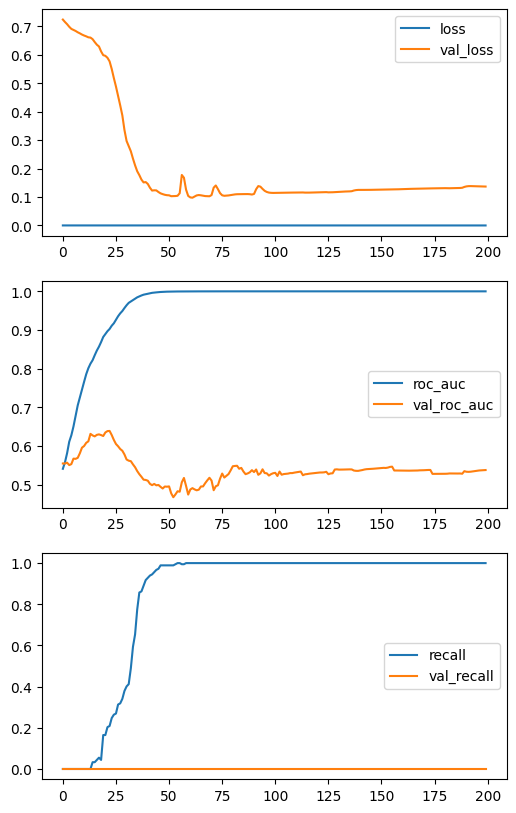

In [19]:
# we plot the information captured throughout training
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6, 10))
df_history = pd.DataFrame(history.history)
df_history.plot(y=['loss', 'val_loss'], ax=ax1)
df_history.plot(y=['roc_auc', 'val_roc_auc'], ax=ax2)
df_history.plot(y=['recall', 'val_recall'], ax=ax3)
plt.show()

The above plots show several curves, the behavior of the two curves with respect to each other gives us a sense of how our model is doing. We can see in the `loss` that the test loss is substantially lower which is to be somewhat expected but the fact that around 50 epochs the validation loss stops going down and in-fact starts going up means we are **overfitting** -- that-is, no longer learning generalizable information and instead sacrificing general performance to fit the training data.

The roc_auc and recall curves tell a similar picture, at around 50 we've "maxed out" on the training set and are not improving on the validation set.

This can be mitigated by adding more data or by augmenting our architecture. We don't have more data so let's see if we can fix the architecture.

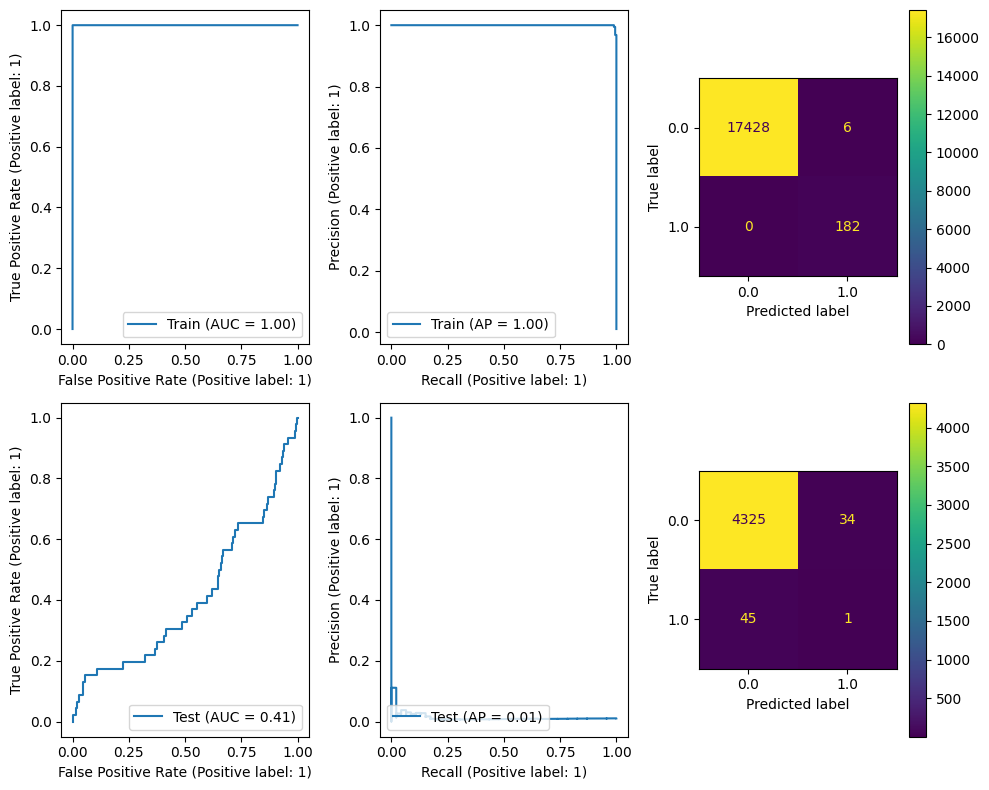

In [20]:
# we plot sklearn-style performance metrics for the trained model
benchmark_classifier(model, X_train, y_train, X_test, y_test, 0.5)

We can see a similar picture reviewing the sklearn-style metrics on the training and test datasets for our trained model. We've almost perfectly learned the training set (besides 6 samples which we think are true, and may in-fact be true) but we are doing horrible on the test dataset, missing absolutely all of the true labels, predicting instead some others.

One way we can tweak our model to mitigate against this is with batch normalization, dropout, or both.

`BatchNormalization` helps to stabalize training by reducing weight distribution shifting from 0 mean, thus discouraging our learned parameters from exploding indefinetly causing numeric instability. The authors suggest applying this layer between the weights and the activation function as we have done, though it can also be applied elsewhere with different effects.

`Dropout` forces the model to generalize more by making some of the weights zero during training, the value provided is the fraction of weights which will be "dropped" randomly during each training pass. This value can have detrimental effects to performance if it's too high but won't work if it's too low, it takes some tuning.

Other than these two additions, our model is the same as before.

In [21]:
tf.keras.utils.set_random_seed(random_state)
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(X.shape[1],)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[
    tf.keras.metrics.AUC(name='roc_auc'),
    tf.keras.metrics.PrecisionAtRecall(0.5, name='recall'),
  ],
)
history = model.fit(
  X_train, y_train,
  shuffle=True,
  class_weight=class_weights,
  validation_data=(X_test, y_test),
  batch_size=X_train.shape[0] // 5,
  epochs=200,
  verbose=0,
)

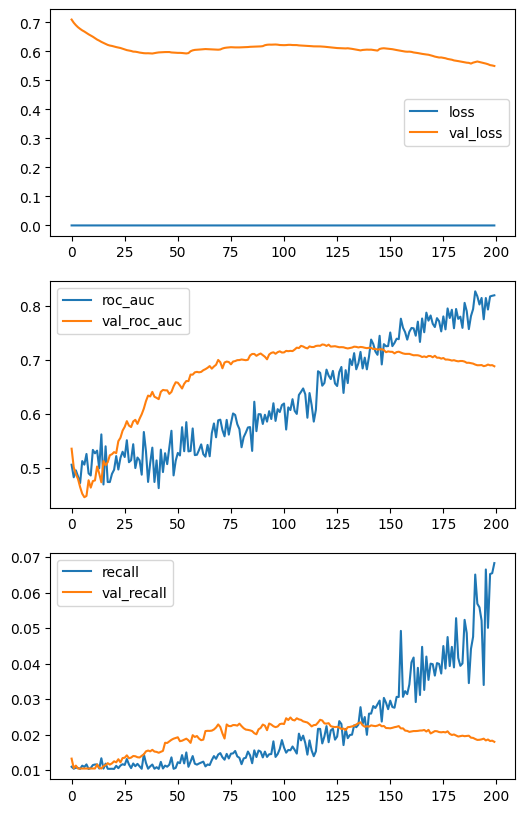

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6, 10))
df_history = pd.DataFrame(history.history)
df_history.plot(y=['loss', 'val_loss'], ax=ax1)
df_history.plot(y=['roc_auc', 'val_roc_auc'], ax=ax2)
df_history.plot(y=['recall', 'val_recall'], ax=ax3)
plt.show()

We can see that our changes caused some different looking training curves. In particular, we can see that the performance on the training data has been "stunted," it is taking a lot longer for the `roc_auc` to reach 1 and in fact it looks like it hasn't made it there yet by 200 epochs.

The validation loss continues to go down throughout the duration of learning which is a good sign but towards the end the roc_auc and recall curves began improving much faster than the validation curves suggesting that we stop learning general information at this point and start overfitting.

More epochs don't seem to be improving things so now, or in-fact about 50 epochs ago would be a good place to stop training.

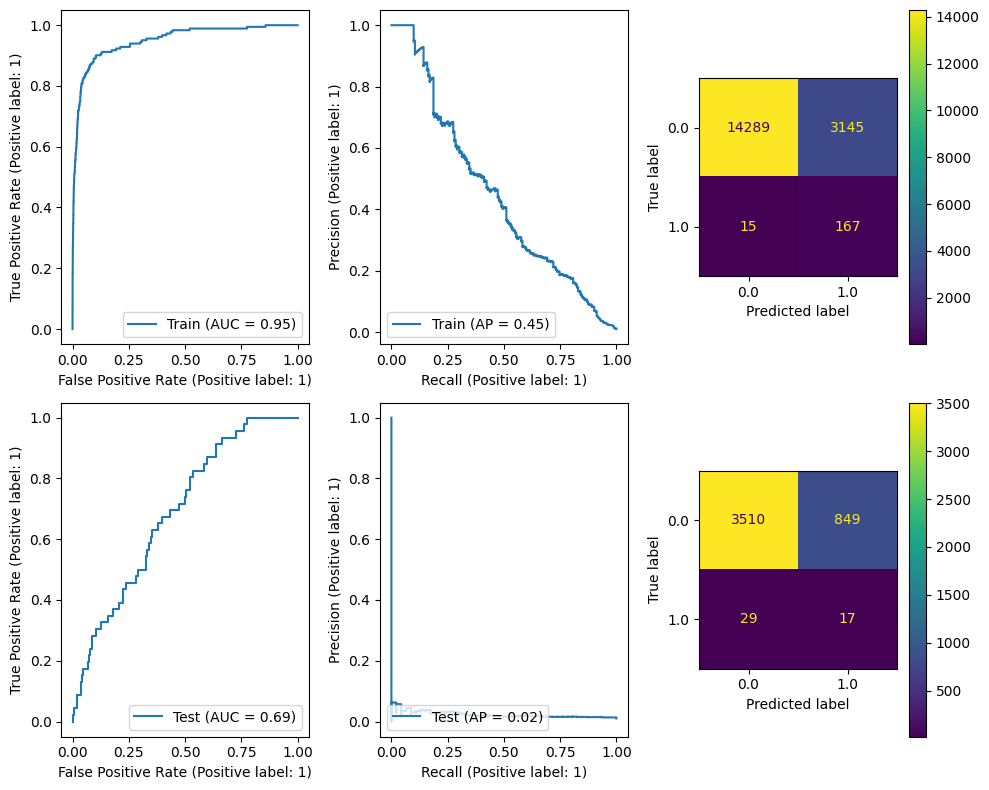

In [23]:
benchmark_classifier(model, X_train, y_train, X_test, y_test, 0.5)

Reviewing the ROC, PR curves and confusion matrix we can see that performance is seemingly better than our previous attempt, certainly on the test dataset, though we're still not able to identify all of the true values so there is still lots of room for improvement.

In any-case, lets see how we export results from these models.

Predictions will be genes which our model is still assigning a high priority despite our training, this we hope is due to the fact that these genes share characteristics in the data that genes we know to be related to eye disease.

Though we are benchmarking on the test set the architecture of our model, after we know that we're able to generalize we can use all the data so that our model has more information to work from.

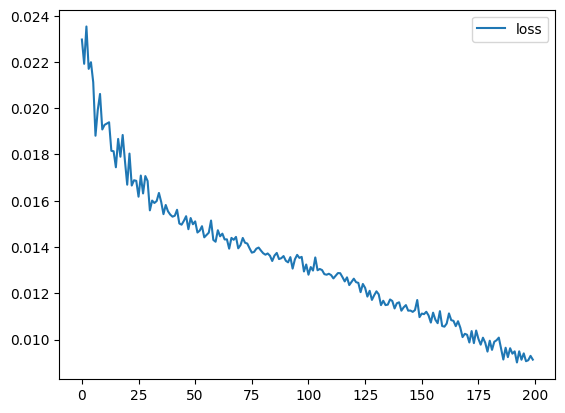

In [25]:
# recompute sample weights on all the data
y_distribution = y.value_counts()
class_weights = (1-y_distribution/y_distribution.sum()).to_dict()

# train on all the data
tf.keras.utils.set_random_seed(random_state)
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(X.shape[1],)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
)
history = model.fit(
  X, y,
  shuffle=True,
  class_weight=class_weights,
  batch_size=X.shape[0] // 5,
  epochs=200,
  verbose=0,
)

df_history = pd.DataFrame(history.history)
df_history.plot(y='loss')
plt.show()

Since we're using all of the data, the other metrics no longer have much meaning and could be misleading given that the model is predicting with data it has used in training.

Instead we're simply reviewing the loss for the duration of training. By loss alone we can see that we have slowed down but we haven't actually stopped learning new information. This could suggest we could still learn more but since we've not yet completely eliminated the overfitting issues in our architecture, we're using the same number of epochs we had before which didn't overfit "too much."

In practice we should go back and continue to tune the architecture until we can eliminate overfitting and then train until the loss has become flat. For the sake of time, we'll use the model as is to show how its predictions can be used.

In [26]:
y_pred_proba = model(X.values).numpy()
predictions = pd.concat([
  pd.DataFrame(y_pred_proba, columns=['y_pred_proba'], index=X.index),
  y.to_frame('y_true'),
], axis=1).sort_values('y_pred_proba', ascending=False)
novel_predictions = predictions[(predictions['y_pred_proba'] > 0.5) & (predictions['y_true']!=1)]
display(predictions.head())
display(novel_predictions.shape[0])
display(novel_predictions.iloc[:10])

y_pred_proba  y_true
NRL         0.985273     1.0
CRYGD       0.978450     1.0
CRYBA4      0.975112     1.0
CRYBA1      0.972253     1.0
PDE6B       0.957827     1.0

2542

y_pred_proba  y_true
ADAMTS1      0.926376     0.0
STAC         0.922711     0.0
GHRH         0.890329     0.0
MOBP         0.889910     0.0
PLA2G5       0.883396     0.0
OLR1         0.881475     0.0
ERBB4        0.878878     0.0
MYBPH        0.878784     0.0
TRIM31       0.877079     0.0
TBC1D24      0.876448     0.0

The output of the model is a prediction probability. We could choose a different cuttoff based on our desired false positive rate by reviewing the ROC & PR curves, or we can consider the simple cutoff of 0.5, considering 0.5 to be a prediction and ordering those predictions by the score the classifier gave.

We can filter out the genes we already know to be associated given that they were part of the original labels and prioritize the predictions. It's important to note that these "probabilities" are simply the scores the model assigned and don't necessarily reflect reality. Though their rankings should be somewhat broadly consistent, they are subject to the stochastic nature of these models meaning that repeated runs may return different top genes.

It would be a good idea to re-run the process several times and look for coherence and also consider that in the model tuning phase along with over/under fitting considerations.